In [1]:
import pandas as pd
import numpy as np
import functools
import keyword

In [2]:
MIN_WORD_COUNT = 'Min Word Count'
MAX_WORD_COUNT = 'Max Word Count'

df200 = pd.read_csv('resources/essays200.csv').drop('Unnamed: 4', axis=1)
df200[MIN_WORD_COUNT] = 150
df200[MAX_WORD_COUNT] = 200
df500 = pd.read_csv('resources/essays500.csv').drop('Unnamed: 4', axis=1) 
df500[MIN_WORD_COUNT] = 500
df500[MAX_WORD_COUNT] = 600
df1000 = pd.read_csv('resources/essays1000.csv').drop('Unnamed: 4', axis=1)
df1000[MIN_WORD_COUNT] = 800
df1000[MAX_WORD_COUNT] = 1200

df = pd.concat([df200, df500, df1000])
df.columns = df.columns \
    .str.strip() \
    .str.lower() \
    .str.replace(' ', '_') \
    .str.replace('(', '') \
    .str.replace(')', '') \
    .str.replace('-','_') \
    .map(lambda x: 'x'+x if x in keyword.kwlist else x )

df.head(5)

/tmp/ipykernel_5280/340073182.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns \
/tmp/ipykernel_5280/340073182.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns \


,essay_title,human_written,ai_written,type,min_word_count,max_word_count
0,Pneumonia: Differential Diagnosis and Primary ...,Penetration of pathogens of pneumonia in the r...,Pneumonia is a common respiratory infection th...,Expository,150,200
1,Relevance and Significance of Communication Te...,The relevance and significance of communicatio...,Communication technology has become an integra...,Persuasive,150,200
2,Technological Objects and Their Capabilities,An innovative home system is one of the unique...,Technological objects have become an integral ...,Expository,150,200
3,Philosophy Teaching and Learning Motivation,Teaching and learning philosophy can be a chal...,Teaching and learning philosophy can be a chal...,Expository,150,200
4,Buddhism and Hinduism: Religious Differences,Buddhism and Hinduism have the same roots. Nev...,Buddhism and Hinduism are two major religions ...,Compare & Contrast,150,200


In [3]:
melted_df = df.melt(id_vars=['essay_title', 'type', 'min_word_count'], value_vars=['human_written', 'ai_written'], var_name='source', value_name='essay')

def convert_label(label):
    return 1 if label == 'human_written' else 0

melted_df['labels'] = melted_df['source'].apply(convert_label)

melted_df = melted_df.sort_values(by=['source', 'essay_title']).reset_index()
melted_df.shape

(150, 7)

In [4]:
train_df = pd.concat([melted_df[:60], melted_df[75:135]])
test_df = pd.concat([melted_df[60:75], melted_df[135:]])

shuffled_train_df = train_df.sample(frac=1).reset_index().drop(['index', 'level_0'], axis=1)
shuffled_test_df = test_df.sample(frac=1).reset_index().drop(['index', 'level_0'], axis=1)
shuffled_train_df.head(5)

,essay_title,type,min_word_count,source,essay,labels
0,"Rocks and Minerals: Aplite, Coal, Quartz, Feld...",Expository,150,human_written,Aplite is an intrusive rock containing the qua...,1
1,Adaptive Immunity: T-Cells and B-Cells,Argumentative,150,human_written,While the doctor is correct in identifying B-c...,1
2,Kirkstall Precision Engineering: Material Requ...,Expository,800,ai_written,Kirkstall Precision Engineering (KPE) is a wel...,0
3,Inclusive Education’ Benefits,Argumentative,800,ai_written,Inclusive education is a type of education sys...,0
4,Adaptive Immunity: T-Cells and B-Cells,Argumentative,150,ai_written,Adaptive immunity is a type of immune response...,0


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

NGRAM_RANGE = (2, 3)

TOP_K = 25000

TOKEN_MODE = 'word'

MIN_DOCUMENT_FREQUENCY = 4

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """

    kwargs = {
            'ngram_range': NGRAM_RANGE, 
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE, 
            'stop_words': 'english',
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val



In [6]:
x_train, x_val = ngram_vectorize(shuffled_train_df['essay'], shuffled_train_df['labels'], shuffled_test_df['essay'])

def to_vector(x):
    df = pd.DataFrame(x.toarray())
    return df.loc[:, (df != 0).any(axis=0)]

vectorized_train_df = to_vector(x_train)
vectorized_test_df = to_vector(x_val)

intersecting_columns = set(vectorized_train_df.columns) & set(vectorized_test_df.columns)
vectorized_train_df = vectorized_train_df[intersecting_columns]
vectorized_test_df = vectorized_test_df[intersecting_columns]

print(len(vectorized_train_df.columns))

# len(vectorized_test_df.columns)

def concatenate_and_cleanup(shuffled_df, vectorized_df):
    vectorized_df = vectorized_df.reindex(sorted(vectorized_df.columns), axis=1)

    for i in range(len(vectorized_df.columns)):
        vectorized_df.rename(columns={vectorized_df.columns[i]: f"feature_{i}"}, inplace=True)
    
    df = pd.concat([shuffled_df, vectorized_df], axis=1)

    return df.sort_values(by=['source', 'essay_title']).reset_index().drop(['index', 'labels'], axis=1)

train_df_with_features = concatenate_and_cleanup(shuffled_train_df, vectorized_train_df)
test_df_with_features =  concatenate_and_cleanup(shuffled_test_df, vectorized_test_df)


/home/suhavni/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2070: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


46


/tmp/ipykernel_5280/3706744550.py:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  vectorized_train_df = vectorized_train_df[intersecting_columns]
/tmp/ipykernel_5280/3706744550.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  vectorized_test_df = vectorized_test_df[intersecting_columns]


## Naive Bayes Classifier

In [7]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB

essay_types = {
    'Analytical': 0,
    'Compare & Contrast': 1,
    'Personal': 2,
    'Persuasive': 3,
    'Argumentative': 4,
    'Expository': 5,
}

def drop_non_features(df):
    df = df.copy()
    df['type'] = df['type'].apply(lambda x: essay_types[x])
    return df.drop(['essay_title', 'essay', 'source'], axis=1)


X_train, y_train = drop_non_features(train_df_with_features), train_df_with_features['source'] == 'ai_written'

# y_train
X_test, y_test = drop_non_features(test_df_with_features), test_df_with_features['source'] == 'ai_written'
X_train.head(5)

,type,min_word_count,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45
0,4,150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,4,800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.364311,0.000000,0.154726,0.000000,0.0,0.205192,0.0,0.000000
2,5,800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.257980,0.171062,0.0,0.000000,0.0,0.455571
3,4,800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,5,800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.257736,0.0,0.000000,0.515472,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [8]:
num_to_type = {v: k for k, v in essay_types.items()}

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [9]:
X_test['min_word_count'].unique()

array([500, 800, 150])

In [10]:
count_correct = 0

essay_type_counts = { k: 0 for k in X_test['type'].unique() }
min_word_counts = { k: 0 for k in X_test['min_word_count'].unique() }

for pred, expected, min_word_count, essay_type in zip(y_pred, y_test, X_test['min_word_count'], X_test['type']):
    if pred == expected:
        count_correct += 1
        min_word_counts[min_word_count] += 1
        essay_type_counts[essay_type] += 1

count_correct / len(y_test)

0.8333333333333334

In [11]:
def get_correctness(d, df, col):
    value_counts = df[col].value_counts()
    return { k: d[k] / value_counts[k] for k in d.keys() }

essay_type_correctness = get_correctness(essay_type_counts, X_test, 'type')
essay_type_correctness = { num_to_type[k]: v for k, v in essay_type_correctness.items() }
min_word_correctness = get_correctness(min_word_counts, X_test, 'min_word_count')

essay_type_correctness

{'Expository': 0.6666666666666666,
 'Personal': 1.0,
 'Argumentative': 0.9285714285714286,
 'Analytical': 0.5,
 'Persuasive': 1.0,
 'Compare & Contrast': 0.5}

In [12]:
min_word_correctness

{500: 0.9, 800: 0.5, 150: 1.0}

/tmp/ipykernel_5280/312819289.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1)


[Text(0, 0.5, 'Human'), Text(0, 1.5, 'AI')]

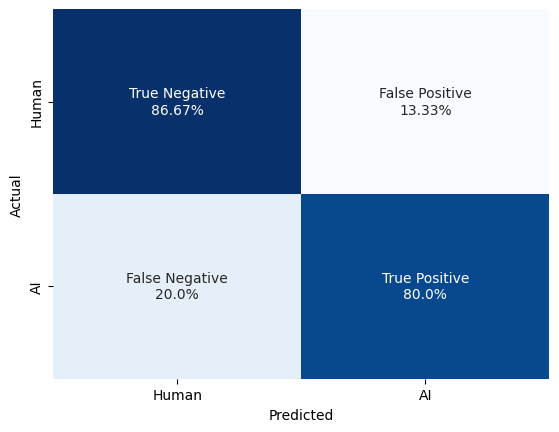

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

group_names = ['True Negative','False Positive','False Negative','True Positive']

cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.astype(np.float).sum(axis=1)

percentages = [f'{(v * 100):.4}%' for v in cm.flatten()]

annotations = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,percentages)]
annotations = np.asarray(annotations).reshape(cm.shape[0], cm.shape[1])

sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.gca().set_xticklabels(['Human', 'AI'])
plt.gca().set_yticklabels(['Human', 'AI'])

AUC: 0.833


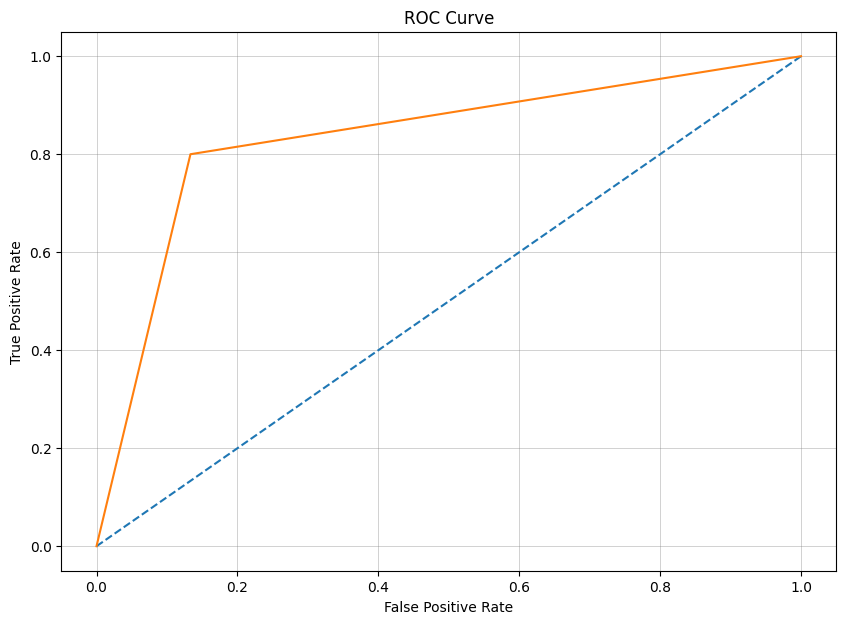

In [22]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# calculate AUC
roc_auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % roc_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plot no skill
plt.figure(figsize=(10, 7))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.grid('--', color='gray', alpha=0.5, lw=0.5)




f1=0.828 auc=0.879 ap=0.786


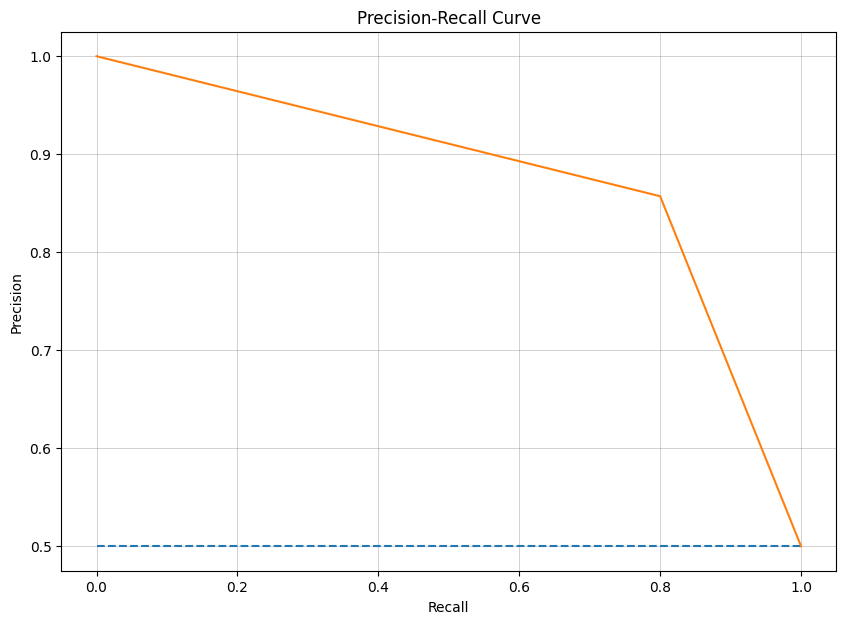

In [21]:
# draw precision-recall curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# calculate F1 score
f1 = f1_score(y_test, y_pred)
# calculate precision-recall AUC
prec_auc = auc(recall, precision)
# calculate average precision score
from sklearn.metrics import average_precision_score
ap = average_precision_score(y_test, y_pred)


print('f1=%.3f auc=%.3f ap=%.3f' % (f1, prec_auc, ap))

plt.figure(figsize=(10, 7))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot precision-recall-curve

plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.grid('--', color='gray', alpha=0.5, lw=0.5)


In [16]:
# compare area under the curve of ROC and precision-recall curve

print('ROC AUC: %.3f' % roc_auc)
print('Precision-Recall AUC: %.3f' % prec_auc)

ROC AUC: 0.833
Precision-Recall AUC: 0.879
